In [348]:
import os
import joblib
import yaml
import copy
import numpy as np
import pandas as pd
from pathlib import Path

from covidcf.config.meta import MetaConfig, MetaSchema

In [614]:
rumc = pd.read_pickle('../data/processed/rumc.pkl')
cwz = pd.read_pickle('../data/processed/cwz.pkl')
ictcf = pd.read_pickle('../data/processed/ictcf.pkl')

In [629]:
import pyperclip
pd.set_option('display.max_colwidth',1000)
pyperclip.copy(pd.DataFrame([
    ['CWZ', 
     f'Random 20% split (excluding training data of CORADS-AI, {int(len(cwz)*0.2)} samples)', 
     f'Remaining data ({int(len(cwz)*0.8)} samples)'], 
    ['iCTCF', f'Second cohort (excluding patients marked as Suspected, {int(len(ictcf[(ictcf.Meta.cohort == "c2") & (ictcf.Target.Metadata_Morbidity != "Suspected")]))} samples)', f'First cohort (excluding patients marked as Suspected, {int(len(ictcf[(ictcf.Meta.cohort == "c1") & (ictcf.Target.Metadata_Morbidity != "Suspected")]))} samples)'], 
    ['RUMC', f'Predefined validation and test splits ({len(rumc[~rumc.Target.pcr.isna() & rumc.Meta.part.isin(["val", "test"])])} samples)', f'Predefined training split ({len(rumc[~rumc.Target.pcr.isna() & rumc.Meta.part.isin(["train"])])})'], 
    ['CWZ: CWZ', 
     f'Data from CWZ hospital ({len(cwz[cwz.Meta.hospital == "cwz"])} samples)', 
     f'Data from RUMC hospital ({len(cwz[cwz.Meta.hospital == "rumc"])} samples)'], 
    ['CWZ: RUMC', 
     f'Data from RUMC hospital ({len(cwz[cwz.Meta.hospital == "rumc"])} samples)', 
     f'Data from CWZ hospital ({len(cwz[cwz.Meta.hospital == "cwz"])} samples)'], 
    ['iCTCF: Liyuan', 
     f'Data from Liyuan hospital (excluding patients marked as Suspected, {len(ictcf[ictcf.Meta.hospital == "Liyuan"])} samples)', 
     f'Data from Union hospital (excluding patients marked as Suspected, {len(ictcf[ictcf.Meta.hospital == "Union"])} samples)'], 
    ['iCTCF: Union', 
     f'Data from Union hospital (excluding patients marked as Suspected, {len(ictcf[ictcf.Meta.hospital == "Union"])} samples)', 
     f'Data from Liyuan hospital (excluding patients marked as Suspected, {len(ictcf[ictcf.Meta.hospital == "Liyuan"])} samples)']
], columns=['Dataset name', 'Test split', 'Training/validation split']).to_latex())


In [311]:
rumc.index = rumc.index.set_levels(rumc.index.levels[0].astype(str), level=0)

In [312]:
rumc = rumc[~rumc.Target.pcr.isna()]

In [169]:
rumc[rumc.Meta.part == 'train'].index.duplicated().any()

False

In [177]:
cwz.loc[~cwz.index.duplicated()].reindex(rumc.index)

Input                ...          Target     Meta
                               Visual                ... COVID_diagnosis hospital
                        vis_feature_0 vis_feature_1  ...                         
patientprimarymrn study                              ...                         
10008             st000           NaN           NaN  ...             NaN      NaN
10017             st000           NaN           NaN  ...             NaN      NaN
10020             st000           NaN           NaN  ...             NaN      NaN
10025             st000           NaN           NaN  ...             NaN      NaN
10033             st000           NaN           NaN  ...             NaN      NaN
...                               ...           ...  ...             ...      ...
10605             st000           NaN           NaN  ...             NaN      NaN
10608             st000           NaN           NaN  ...             NaN      NaN
10610             st000           NaN           NaN  ...             NaN      NaN
10611             st000           NaN           NaN  ...             NaN      NaN
10614             st000           NaN           NaN  ...             NaN      NaN

[155 rows x 90 columns]

In [314]:
len(cwz.index.intersection(rumc.index))

41

In [587]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

while True:
#     seed = np.random.randint(100000)
    seed = 38107
#     print(seed)
    splitter = ShuffleSplit(n_splits=1, random_state=seed)
    split_train, split = next(splitter.split(cwz.Input, cwz.Target.diagnosis))
    intersect_size = len(cwz.iloc[split, :].loc[~cwz.iloc[split, :].index.duplicated()].index.intersection(rumc[rumc.Meta.part == 'train'].index))
    print(cwz.iloc[split_train, :].Input.Visual.isna().all(axis=1).sum())
    print(intersect_size)
    if intersect_size == 0:
        print(seed)
        break
#     print(split)
#     break
#     cwz.loc[~cwz.index.duplicated()].reindex(rumc[rumc.Meta.part == 'train'].index)

10
0
38107


In [588]:
def load_config(path: Path):
    with open(path, 'r') as fh:
        config = yaml.load(fh, Loader=yaml.SafeLoader)
    return path.stem, config

def generate_experiment(name: str, configs, datasets, features, do_hyperopt: bool, generate_configs_callback, overview_metrics=None, 
                        overview_x='model', overview_row=None, plot_shap=False, n_hyperopt_trials: int = 25, hyperopt_cv=None, exclude_configs=None, 
                        stratified: bool = True):
    base_path = Path('../experiments/')
    experiment_path = base_path.joinpath(name)
    experiment_path.mkdir(parents=True, exist_ok=True)
    
    exclude_configs = [] if exclude_configs is None else exclude_configs
    configs_path = Path('../configs/base_learners_hyperopt/') if do_hyperopt else Path('../configs/base_learners/')
    if configs == 'all' or len(set(configs)) == len(configs):
        base_configs = [load_config(path) for path in configs_path.iterdir() if (path.stem in configs or configs == 'all') and not path.stem in exclude_configs]
    else:
        base_configs = [load_config(configs_path.joinpath(f'{stem}.yaml')) for stem in configs]

#     seed = np.random.randint(1000000)
    if datasets == 'all':
        datasets = ['rumc', 'ictcf', 'cwz']
        test_cvs = {'cwz': dict(test_size=0.2, seed=38107, stratified=stratified), 
                    'ictcf': dict(part_name='cohort', part='c2'), 
                    #'rumc': dict(part_name='part', part='test')}
#                     'rumc': dict(test_size=0.3333, seed=seed, stratified=stratified)}
                    'rumc': dict(part_name='part', part=['test', 'val'])}
                    
    elif datasets == 'cross':
        datasets = ['ictcf_Union', 'ictcf_Liyuan', 'cwz_cwz', 'cwz_rumc']
        test_cvs = {'ictcf_Union': dict(part_name='hospital', part='Union'), 
                    'ictcf_Liyuan': dict(part_name='hospital', part='Liyuan'), 
                    'cwz_cwz': dict(part_name='hospital', part='cwz'), 
                    'cwz_rumc': dict(part_name='hospital', part='rumc')}
    
    if features == 'all':
        features = [(True, True), (True, False)]
    feat_names = {(True, True): 'combined', (True, False): 'clinical', (False, True): 'visual'}
    
    overview_metrics = {'Precision': 'precision', 'Recall': 'recall', 'F1': 'f1', 'AUC': 'roc_auc'} if overview_metrics is None else overview_metrics
    
    hyperopt_cv = dict(n_folds=5, n_repeats=5) if hyperopt_cv is None else hyperopt_cv
    
    for dataset in datasets:
        meta = MetaConfig(overview=MetaConfig.OverviewConfig(x=overview_x, row=overview_row, metrics=overview_metrics), 
                          plot_shap=plot_shap, adjust_thresholds=dataset=='rumc')
        
        for feat in features:
            path = experiment_path.joinpath(dataset).joinpath(feat_names[feat])
            path.mkdir(parents=True, exist_ok=True)
            with open(path.joinpath('meta.yaml'), 'w') as fh:
                yaml.dump(MetaSchema.dump(meta), fh)
            for conf_index, (name, conf) in enumerate(base_configs):
                c = copy.deepcopy(conf)
                c['dataset']['name'] = dataset.split('_')[0]
                c['dataset']['target'] = 'PCR' if dataset.split('_')[0] in ['rumc', 'ictcf'] else 'DIAGNOSIS'
                c['dataset']['test'] = dict(cv=test_cvs[dataset])
                c['dataset']['use_clinical_features'] = feat[0]
                c['dataset']['use_visual_features'] = feat[1]

                if do_hyperopt:
                    if name == 'rf_sklearn':
                        c['n_trials'] = 30
                    elif name == 'lr':
                        c['n_trials'] = 50
                    else:
                        c['n_trials'] = n_hyperopt_trials
                    c['dataset']['validation'] = dict(metric='roc_auc', cv=hyperopt_cv)

                try:
                    experiments_configs = generate_configs_callback(dataset, feat, name, c, conf_index)
                except:
                    experiments_configs = generate_configs_callback(dataset, feat, name, c)
                for experiment_name, experiment_config in experiments_configs:
                    with open(path.joinpath(f'{experiment_name}.yaml'), 'w') as fh:
                        yaml.dump(experiment_config, fh)

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True)


RandomForestClassifier(n_jobs=12)

In [103]:
from lightgbm.sklearn import LGBMClassifier
rf = LGBMClassifier(n_jobs=-1, n_estimators=200)

In [104]:
%%timeit
rf.fit(X, y)

225 ms ± 5.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [334]:
models = ['bagged_gbdt', 'gbdt', 'lr', 'rf_sklearn']
models_hyperopt = ['gbdt', 'lr', 'rf_sklearn']

## Basic shit

In [607]:
def gen_configs(dataset, feat, config_name, config):
    c = copy.deepcopy(config)
    yield config_name, c

generate_experiment('within_dataset', configs=models, datasets='all', features='all', do_hyperopt=False, 
                    generate_configs_callback=gen_configs, plot_shap=True)
generate_experiment('within_dataset_hyperopt', configs=models_hyperopt, datasets='all', features='all', do_hyperopt=True, 
                    generate_configs_callback=gen_configs, plot_shap=False, exclude_configs=['bagged_gbdt'], n_hyperopt_trials=90)

generate_experiment('between_dataset', configs=models, datasets='cross', features='all', do_hyperopt=False, 
                    generate_configs_callback=gen_configs, plot_shap=True)
generate_experiment('between_dataset_hyperopt', configs=models_hyperopt, datasets='cross', features='all', do_hyperopt=True, 
                    generate_configs_callback=gen_configs, plot_shap=False, exclude_configs=['bagged_gbdt'], n_hyperopt_trials=90)

## Evaluate missingness

In [599]:
def gen_configs(dataset, feat, config_name, config):
    c = copy.deepcopy(config)
    c['dataset']['feature_value_fraction_required'] = 0.005
    c['pipeline']['missing_indicators'] = True
    yield config_name, c

generate_experiment('within_dataset_missing', configs=models, datasets='all', features='all', do_hyperopt=False, 
                    generate_configs_callback=gen_configs)

In [600]:
def gen_configs(dataset, feat, config_name, config):
    impute_methods = ['MEAN', 'MEDIAN', 'MICE', 'KNN3', 'KNN5', 'KNN10', 'CONSTANT']
#     impute_methods = ['MEAN', 'MEDIAN', 'MICE', 'KNN3', 'KNN5', 'KNN10', 'CONSTANT']
    # FIXME: Is this using the right splitting???
    for impute in impute_methods:
        c = copy.deepcopy(config)
        c['dataset']['target'] = 'MISSING'
        c['dataset']['feature_value_fraction_required'] = 0.05
        c['pipeline']['imputation']['numeric'] = impute
        c['meta']['impute'] = impute
        c['pipeline']['estimator_type'] = 'MULTI_LGBM'
        c['parameters'] = dict(estimator=dict(base_estimator=c['parameters']['estimator']))
        yield impute, c

generate_experiment('impute_predict_missing', configs='gbdt', datasets='all', features=[(True, True)], do_hyperopt=False, 
                    generate_configs_callback=gen_configs, overview_x='impute', stratified=False)

## Mitigate missingness

### Cross-hospital

In [601]:
def gen_configs(dataset, feat, config_name, config):
#     impute_methods = ['MEAN', 'MEDIAN', 'MICE', 'KNN3', 'KNN5', 'KNN10', 'CONSTANT']
    if config_name == 'bagged_gbdt':
        impute_methods = ['MEAN', 'KNN5']
    else:
        impute_methods = ['MEAN', 'MICE',  'KNN5']
    for impute in impute_methods:
        c = copy.deepcopy(config)
#         c['dataset']['feature_value_fraction_required'] = 0.01
        c['pipeline']['imputation']['numeric'] = impute
#         c['parameters']['estimator']['n_estimators'] = 100
        c['meta'].update(dict(impute_method=impute))
        yield f'{config_name}_{impute}', c
generate_experiment('predict_with_impute', configs=models, datasets='cross', features='all', do_hyperopt=False, generate_configs_callback=gen_configs, 
                    overview_row='impute_method')

In [611]:
def gen_configs(dataset, feat, config_name, config):
    c = copy.deepcopy(config)
#     c['pipeline']['imputation']['categorical'] = 'NONE'
#     c['pipeline']['imputation']['numeric'] = 'NONE'
    if config_name == 'gbdt':
        c['parameters']['estimator']['linear_tree'] = False
    if 'estimator' in c['parameters']:
        c['parameters'] = dict(estimator=dict(base_estimator=c['parameters']['estimator']))
    else:
        c['parameters'] = dict(base_estimator=dict(estimator=dict(base_estimator=c['parameters']['base_estimator']['estimator'])))
    c['pipeline']['special'] = 'SHAP_ZERO'
    yield f'{config_name}', c
generate_experiment('shap_zeroing', configs=models, datasets='cross', features='all', do_hyperopt=False, 
                    generate_configs_callback=gen_configs)
generate_experiment('shap_zeroing_hyperopt', configs=['gbdt', 'rf_sklearn'], datasets='cross', features='all', do_hyperopt=True, 
                    generate_configs_callback=gen_configs, n_hyperopt_trials=90)

In [613]:
def gen_configs(dataset, feat, config_name, config):
    c = copy.deepcopy(config)
    c['pipeline']['imputation']['categorical'] = 'NONE'
    c['pipeline']['imputation']['numeric'] = 'NONE'
    if config_name == 'bagged_gbdt':
        c['parameters'] = dict(base_estimator=dict(estimator=dict(base_estimator=c['parameters']['base_estimator']['estimator'])))
        c['parameters']['base_estimator']['estimator']['n_repeat'] = 30
        c['pipeline']['n_bagging'] = 50
    else:
        c['parameters'] = dict(estimator=dict(base_estimator=c['parameters']['estimator']))
        if config_name == 'rf_sklearn':
            c['parameters']['estimator']['n_repeat'] = 20
        else:
            c['parameters']['estimator']['n_repeat'] = 100
    c['pipeline']['special'] = 'REP_IMPUTE'
    yield f'{config_name}', c
generate_experiment('test_time_impute', configs=['gbdt', 'lr'], datasets='cross', features='all', do_hyperopt=False, 
                    generate_configs_callback=gen_configs, plot_shap=True)

### Within dataset

In [604]:
def gen_configs(dataset, feat, config_name, config):
#     impute_methods = ['MEAN', 'MEDIAN', 'MICE', 'KNN3', 'KNN5', 'KNN10', 'CONSTANT']
    if config_name == 'bagged_gbdt':
        impute_methods = ['MEAN', 'KNN5']
    else:
        impute_methods = ['MEAN', 'MICE',  'KNN5']
    for impute in impute_methods:
        c = copy.deepcopy(config)
#         c['dataset']['feature_value_fraction_required'] = 0.005
        c['pipeline']['imputation']['numeric'] = impute
#         c['parameters']['estimator']['n_estimators'] = 100
        c['meta'].update(dict(impute_method=impute))
        yield f'{config_name}_{impute}', c
generate_experiment('within_predict_with_impute', configs=models, datasets='all', features='all', do_hyperopt=False, generate_configs_callback=gen_configs, 
                    overview_row='impute_method')

In [609]:
def gen_configs(dataset, feat, config_name, config):
    c = copy.deepcopy(config)
#     c['pipeline']['imputation']['categorical'] = 'NONE'
#     c['pipeline']['imputation']['numeric'] = 'NONE'
    if config_name == 'gbdt':
        c['parameters']['estimator']['linear_tree'] = False
    if 'estimator' in c['parameters']:
        c['parameters'] = dict(estimator=dict(base_estimator=c['parameters']['estimator']))
    else:
        c['parameters'] = dict(base_estimator=dict(estimator=dict(base_estimator=c['parameters']['base_estimator']['estimator'])))
    c['pipeline']['special'] = 'SHAP_ZERO'
    yield f'{config_name}', c
generate_experiment('within_shap_zeroing', configs=models, datasets='all', features='all', do_hyperopt=False, 
                    generate_configs_callback=gen_configs)
generate_experiment('within_shap_zeroing_hyperopt', configs=['gbdt'], datasets='all', features='all', do_hyperopt=True, 
                    generate_configs_callback=gen_configs, n_hyperopt_trials=64)

In [630]:
def gen_configs(dataset, feat, config_name, config):
    c = copy.deepcopy(config)
    c['pipeline']['imputation']['categorical'] = 'NONE'
    c['pipeline']['imputation']['numeric'] = 'NONE'
    if config_name == 'bagged_gbdt':
        c['parameters'] = dict(base_estimator=dict(estimator=dict(base_estimator=c['parameters']['base_estimator']['estimator'])))
        c['parameters']['base_estimator']['estimator']['n_repeat'] = 50
        c['pipeline']['n_bagging'] = 100
    else:
        c['parameters'] = dict(estimator=dict(base_estimator=c['parameters']['estimator']))
        if config_name == 'rf_sklearn':
            c['parameters']['estimator']['n_repeat'] = 20
        else:
            c['parameters']['estimator']['n_repeat'] = 100
    c['pipeline']['special'] = 'REP_IMPUTE'
    yield f'{config_name}', c
generate_experiment('within_test_time_impute', configs=['gbdt', 'lr'], datasets='all', features='all', do_hyperopt=False, 
                    generate_configs_callback=gen_configs, plot_shap=True)

In [39]:
def get_best_model(path, features='clinical'):
    datasets = ['ictcf_Union', 'ictcf_Liyuan', 'cwz_cwz', 'cwz_rumc']
    dfs = [pd.read_csv(os.path.join(path, dataset, features, 'results/data.csv'), index_col=0) for dataset in datasets]
    return (sum(df[(df.metric == 'AUC') & (df.model != 'Baseline')].set_index(list(df.columns[5:])).value for df in dfs)/4).idxmax(), (sum(df[(df.metric == 'AUC') & (df.model != 'Baseline')].set_index(list(df.columns[5:])).value for df in dfs)/4).max()
#     return df.loc[df[df.metric == 'AUC'].value.idxmax()][5:].item()

In [410]:
print('Best base: ', get_best_model('../experiments/between_dataset/'))
print('Best impute: ', get_best_model('../experiments/predict_with_impute/'))
print('Best shap zeroing: ', get_best_model('../experiments/shap_zeroing/'))
print('Best shap zeroing hyperopt: ', get_best_model('../experiments/shap_zeroing_hyperopt/'))
print('Best test time impute: ', get_best_model('../experiments/test_time_impute/'))

Best base:  ('BaggedGBDT', 0.7467053288598957)
Best impute:  (('CONSTANT', 'DART'), 0.7480144149964639)
Best shap zeroing:  ('DART', 0.7274333260511111)
Best shap zeroing hyperopt:  ('GOSS', 0.7310264303748268)
Best test time impute:  ('GOSS', 0.6977404395437442)


In [412]:
def gen_configs(dataset, feat, config_name, config, conf_index):
    print(dataset, feat, config_name, conf_index)
    c = copy.deepcopy(config)
    name = config_name
    if conf_index == 1:
        c['dataset']['feature_value_fraction_required'] = 0.005
        c['pipeline']['imputation']['numeric'] = 'CONSTANT'
#         c['meta']['impute_method'] = 'CONSTANT'
        c['meta']['model'] = c['meta']['model'] + ' with impute'
        name = 'impute_'+name
    elif conf_index == 2:
        c['n_trials'] = 80
        c['dataset']['validation'] = dict(metric='roc_auc', cv=dict(n_folds=5, n_repeats=3))
        c['meta']['model'] = c['meta']['model'] + ' with Shapley zeroing'
        name = 'shap_zero_'+name
    elif conf_index == 3:
        c['parameters'] = dict(estimator=dict(base_estimator=c['parameters']['estimator']))
        c['parameters']['estimator']['n_repeat'] = 150
        c['pipeline']['estimator_type'] = 'REP_IMPUTE'
        c['meta']['model'] = c['meta']['model'] + ' with test-time impute'
        name = 'test_time_impute_'+name
    yield name, c
#     c = copy.deepcopy(config)
#     c['']
#     yield f'{config_name}', c
#     if config_name == 'gbdt':
#         c = copy.deepcopy(config)
#         c['meta']['model'] = 'Baseline'
#         yield f'{config_name}_base', c
generate_experiment('overview', configs=['bagged_gbdt', 'dart', 'goss', 'goss'], datasets='cross', features='all', do_hyperopt=False, 
                    generate_configs_callback=gen_configs, plot_shap=True)

ictcf_Union (True, True) bagged_gbdt 0
ictcf_Union (True, True) dart 1
ictcf_Union (True, True) goss 2
ictcf_Union (True, True) goss 3
ictcf_Union (True, False) bagged_gbdt 0
ictcf_Union (True, False) dart 1
ictcf_Union (True, False) goss 2
ictcf_Union (True, False) goss 3
ictcf_Liyuan (True, True) bagged_gbdt 0
ictcf_Liyuan (True, True) dart 1
ictcf_Liyuan (True, True) goss 2
ictcf_Liyuan (True, True) goss 3
ictcf_Liyuan (True, False) bagged_gbdt 0
ictcf_Liyuan (True, False) dart 1
ictcf_Liyuan (True, False) goss 2
ictcf_Liyuan (True, False) goss 3
cwz_cwz (True, True) bagged_gbdt 0
cwz_cwz (True, True) dart 1
cwz_cwz (True, True) goss 2
cwz_cwz (True, True) goss 3
cwz_cwz (True, False) bagged_gbdt 0
cwz_cwz (True, False) dart 1
cwz_cwz (True, False) goss 2
cwz_cwz (True, False) goss 3
cwz_rumc (True, True) bagged_gbdt 0
cwz_rumc (True, True) dart 1
cwz_rumc (True, True) goss 2
cwz_rumc (True, True) goss 3
cwz_rumc (True, False) bagged_gbdt 0
cwz_rumc (True, False) dart 1
cwz_rumc (Tr

In [415]:
def gen_configs(dataset, feat, config_name, config, conf_index):
    print(dataset, feat, config_name, conf_index)
    c = copy.deepcopy(config)
    name = config_name
    if conf_index == 1:
        c['dataset']['feature_value_fraction_required'] = 0.005
        c['pipeline']['imputation']['numeric'] = 'CONSTANT'
#         c['meta']['impute_method'] = 'CONSTANT'
        c['meta']['model'] = c['meta']['model'] + ' with impute'
        name = 'impute_'+name
    elif conf_index == 2:
        c['n_trials'] = 50
        c['dataset']['validation'] = dict(metric='roc_auc', cv=dict(n_folds=5, n_repeats=3))
        c['meta']['model'] = c['meta']['model'] + ' with Shapley zeroing'
        name = 'shap_zero_'+name
    elif conf_index == 3:
        c['parameters'] = dict(estimator=dict(base_estimator=c['parameters']['estimator']))
        c['parameters']['estimator']['n_repeat'] = 120
        c['pipeline']['estimator_type'] = 'REP_IMPUTE'
        c['meta']['model'] = c['meta']['model'] + ' with test-time impute'
        name = 'test_time_impute_'+name
    yield name, c
#     c = copy.deepcopy(config)
#     c['']
#     yield f'{config_name}', c
#     if config_name == 'gbdt':
#         c = copy.deepcopy(config)
#         c['meta']['model'] = 'Baseline'
#         yield f'{config_name}_base', c
generate_experiment('overview_within', configs=['bagged_gbdt', 'dart', 'goss', 'goss'], datasets='all', features='all', do_hyperopt=False, 
                    generate_configs_callback=gen_configs, plot_shap=False)

rumc (True, True) bagged_gbdt 0
rumc (True, True) dart 1
rumc (True, True) goss 2
rumc (True, True) goss 3
rumc (True, False) bagged_gbdt 0
rumc (True, False) dart 1
rumc (True, False) goss 2
rumc (True, False) goss 3
ictcf (True, True) bagged_gbdt 0
ictcf (True, True) dart 1
ictcf (True, True) goss 2
ictcf (True, True) goss 3
ictcf (True, False) bagged_gbdt 0
ictcf (True, False) dart 1
ictcf (True, False) goss 2
ictcf (True, False) goss 3
cwz (True, True) bagged_gbdt 0
cwz (True, True) dart 1
cwz (True, True) goss 2
cwz (True, True) goss 3
cwz (True, False) bagged_gbdt 0
cwz (True, False) dart 1
cwz (True, False) goss 2
cwz (True, False) goss 3


In [376]:
x.columns[5:].values

array(['impute_method', 'model'], dtype=object)

In [384]:
x[x.metric == 'AUC'].set_index(list(x.columns[5:])).value

impute_method  model    
CONSTANT       DART         0.877706
               GBDT         0.773152
               GOSS         0.773152
               LR           0.797387
               RF           0.839054
               RFsklearn    0.882769
KNN10          DART         0.888219
               GBDT         0.750425
               GOSS         0.811263
               LR           0.863868
               RF           0.833604
               RFsklearn    0.879831
KNN3           DART         0.845161
               GBDT         0.770060
               GOSS         0.770060
               LR           0.846784
               RF           0.850997
               RFsklearn    0.878904
KNN5           DART         0.858071
               GBDT         0.786797
               GOSS         0.786797
               LR           0.848176
               RF           0.864255
               RFsklearn    0.861511
MEAN           DART         0.870516
               GBDT         0.788575
             

In [383]:
x

,metric,feat,value,lb,ub,impute_method,model
0,AUC,0,0.877706,0.837764,0.916180,CONSTANT,DART
1,F1,0,0.882217,0.851578,0.915487,CONSTANT,DART
2,Precision,0,0.805907,0.753072,0.856207,CONSTANT,DART
3,Recall,0,0.974490,0.949679,0.994978,CONSTANT,DART
4,AUC,0,0.773152,0.710162,0.824586,CONSTANT,GBDT
...,...,...,...,...,...,...,...
179,Recall,0,0.892857,0.858555,0.932521,NONE,GOSS
180,AUC,0,0.850495,0.806696,0.895634,NONE,RF
181,F1,0,0.848780,0.812769,0.887366,NONE,RF
182,Precision,0,0.813084,0.766498,0.873136,NONE,RF


In [370]:
pd.DataFrame(data=x[x.metric == 'AUC'].value, index=x[x.metric == 'AUC'].iloc[:, 5:])

,value
"(CONSTANT, DART)",NaN
"(CONSTANT, GBDT)",NaN
"(CONSTANT, GOSS)",NaN
"(CONSTANT, LR)",NaN
"(CONSTANT, RF)",NaN
"(CONSTANT, RFsklearn)",NaN
"(KNN10, DART)",NaN
"(KNN10, GBDT)",NaN
"(KNN10, GOSS)",NaN
"(KNN10, LR)",NaN


In [ ]:
pd.read_pickle('../experiments/between_dataset/cwz_cwz/clinical/')

In [45]:
import pandas as pd

In [28]:
pd.read_pickle('../data/processed/cwz.pkl').Input.Clinical.isna().sum().head(30)

dem_pat_age_at_inclusion                                     0
dem_pat_gender                                               0
dem_pat_BMI                                                180
med_hist_other#Cardiovascular                                0
med_hist_other#DM                                            0
med_hist_other#Obesity                                       0
med_hist_other#Pulmonary_Pathology                           0
med_hist_other#Immunodeficiency                              0
med_hist_other#Malignancy                                    0
med_hist_other#Other                                         0
adm_symptoms_duration                                       14
adm_presenting_symptoms#Fever__38_C                          0
adm_presenting_symptoms#Cough_without_sputum_production      0
adm_presenting_symptoms#Shortness_of_breath_dyspnea          0
adm_presenting_symptoms#Chest_pain                           0
adm_presenting_symptoms#Abdominal_pain                 

In [327]:
results = pd.read_csv('../experiments/within_dataset/cwz/clinical/results/data.csv', index_col=0)
results

,metric,feat,value,lb,ub,model
0,AUC,0,0.845899,0.819693,0.868309,BaggedGBDT
1,F1,0,0.861314,0.798103,0.852417,BaggedGBDT
2,Precision,0,0.797297,0.709783,0.875875,BaggedGBDT
3,Recall,0,0.936508,0.911070,0.963665,BaggedGBDT
4,AUC,0,0.835317,0.819373,0.866664,DART
5,F1,0,0.833333,0.787428,0.857608,DART
6,Precision,0,0.797101,0.777065,0.887208,DART
7,Recall,0,0.873016,0.828721,0.906286,DART
8,AUC,0,0.844577,0.785872,0.920331,GBDT
9,F1,0,0.850746,0.807552,0.873552,GBDT


In [329]:
df_pivot = pd.pivot(results, values=['value', 'lb', 'ub'], index='model', columns='metric')
df_output = pd.pivot(results, values='value', index='model', columns='metric')

In [330]:
for i, metric in enumerate(df_output.columns):
    df_output.insert(2*i+1, metric+'_bar', 0)
    for model in df_output[metric].index:
        df_output.loc[model, metric+'_bar'] = f'bar({df_pivot.value.loc[model, metric]:.3f}, {df_pivot.lb.loc[model, metric]:.3f}, {df_pivot.ub.loc[model, metric]:.3f})'

In [331]:
def round_to_3(x):
    print(x, type(x))
    if not isinstance(x, str):
        return f'{x:.3f}'
    else:
        x = float(x.replace('max_', ''))
        return f'\\textbf{{{x:.3f}}}'
for col in df_output.columns:
    if '_bar' in col:
        continue
    is_max = df_output[col]==df_output[col].max()
    df_output.loc[is_max, col] = f'\\textbf{{{df_output[col].max():.3f}}}'
    df_output.loc[~is_max, col] = [f'{x:.3f}' for x in df_output.loc[~is_max, col]]
    

In [333]:
df_output.index.names = ['ewfewf']

In [335]:
df_output.index

Index(['BaggedGBDT', 'DART', 'GBDT', 'GOSS', 'LR', 'RF', 'RFsklearn'], dtype='object', name='ewfewf')

In [321]:
df_output.index.names = [n[0].upper()+n[1:].replace('_', ' ') for n in df_output.index.names]

In [323]:
df_output.columns.name = df_output.columns.name[0].upper()+df_output.columns.name[1:].replace('_', ' ')

In [324]:
df_output

Metric                               AUC                   AUC_bar  \
Model      Impute method                                             
BaggedGBDT NONE                    0.736  bar(0.736, 0.701, 0.753)   
DART       CONSTANT                0.772  bar(0.772, 0.766, 0.793)   
           KNN10                   0.726  bar(0.726, 0.687, 0.760)   
           KNN3                    0.773  bar(0.773, 0.744, 0.833)   
           KNN5                    0.719  bar(0.719, 0.700, 0.804)   
           MEAN                    0.695  bar(0.695, 0.622, 0.729)   
           MEDIAN         \textbf{0.800}  bar(0.800, 0.803, 0.863)   
           MICE                    0.686  bar(0.686, 0.625, 0.693)   
           NONE                    0.697  bar(0.697, 0.660, 0.743)   
GBDT       CONSTANT                0.667  bar(0.667, 0.670, 0.736)   
           KNN10                   0.659  bar(0.659, 0.651, 0.722)   
           KNN3                    0.763  bar(0.763, 0.659, 0.730)   
           KNN5                    0.737  bar(0.737, 0.707, 0.780)   
           MEAN                    0.689  bar(0.689, 0.674, 0.700)   
           MEDIAN                  0.669  bar(0.669, 0.651, 0.751)   
           MICE                    0.699  bar(0.699, 0.642, 0.727)   
           NONE                    0.722  bar(0.722, 0.672, 0.729)   
GOSS       CONSTANT                0.667  bar(0.667, 0.641, 0.697)   
           KNN10                   0.659  bar(0.659, 0.614, 0.680)   
           KNN3                    0.738  bar(0.738, 0.716, 0.791)   
           KNN5                    0.692  bar(0.692, 0.680, 0.795)   
           MEAN                    0.679  bar(0.679, 0.688, 0.718)   
           MEDIAN                  0.669  bar(0.669, 0.617, 0.693)   
           MICE                    0.708  bar(0.708, 0.679, 0.759)   
           NONE                    0.735  bar(0.735, 0.698, 0.807)   
RF         CONSTANT                0.700  bar(0.700, 0.695, 0.736)   
           KNN10                   0.730  bar(0.730, 0.681, 0.757)   
           KNN3                    0.732  bar(0.732, 0.672, 0.740)   
           KNN5                    0.750  bar(0.750, 0.684, 0.738)   
           MEAN                    0.740  bar(0.740, 0.679, 0.758)   
           MEDIAN                  0.739  bar(0.739, 0.724, 0.807)   
           MICE                    0.754  bar(0.754, 0.713, 0.748)   
           NONE                    0.708  bar(0.708, 0.675, 0.767)   
RFsklearn  CONSTANT                0.756  bar(0.756, 0.722, 0.774)   
           KNN10                   0.763  bar(0.763, 0.700, 0.751)   
           KNN3                    0.758  bar(0.758, 0.745, 0.828)   
           KNN5                    0.774  bar(0.774, 0.743, 0.790)   
           MEAN                    0.772  bar(0.772, 0.755, 0.793)   
           MEDIAN                  0.777  bar(0.777, 0.738, 0.784)   
           MICE                    0.759  bar(0.759, 0.802, 0.846)   

Metric                                F1                    F1_bar  \
Model      Impute method                                             
BaggedGBDT NONE                    0.814  bar(0.814, 0.771, 0.841)   
DART       CONSTANT                0.818  bar(0.818, 0.805, 0.843)   
           KNN10                   0.816  bar(0.816, 0.795, 0.843)   
           KNN3                    0.811  bar(0.811, 0.810, 0.843)   
           KNN5                    0.818  bar(0.818, 0.791, 0.851)   
           MEAN                    0.814  bar(0.814, 0.781, 0.835)   
           MEDIAN                  0.828  bar(0.828, 0.828, 0.869)   
           MICE                    0.819  bar(0.819, 0.764, 0.847)   
           NONE                    0.814  bar(0.814, 0.791, 0.833)   
GBDT       CONSTANT                0.814  bar(0.814, 0.782, 0.826)   
           KNN10                   0.814  bar(0.814, 0.786, 0.868)   
           KNN3                    0.823  bar(0.823, 0.806, 0.827)   
           KNN5           \textbf{0.832}  bar(0.832, 0.809, 0.877)   
         

In [325]:
latex = (df_output.rename(columns={col: '' for col in df_output.columns if '_bar' in col})
                 .to_latex(escape=False))

In [326]:
import re
for match in re.finditer(r'bar\((\d+\.\d+), (\d+\.\d+), (\d+\.\d+)\)', latex):
    value = float(match.group(1))-0.5
    lb = float(match.group(2))-0.5
    ub = float(match.group(3))-0.5
    
    scale_factor = 2.4
    y1 = 0.06
    y2 = 0.352
    yh = (y1+y2)/2
    yd = 0.04
    yb1 = yh-yd
    yb2 = yh+yd
    
    latex = latex.replace(match.group(0), r'''\begin{minipage}[c]{1.2cm}
   \begin{tikzpicture}
    \draw (0cm,0cm) (5,0);
    \draw[barchart] (0,'''+str(y1)+''') rectangle ('''+str(value*scale_factor)+''','''+str(y2)+''');
    \draw[errorbar] ('''+str(lb*scale_factor)+''','''+str(yh)+''') -- ('''+str(ub*scale_factor)+''','''+str(yh)+''');
    \draw[errorbar] ('''+str(lb*scale_factor)+''','''+str(yb2)+''') -- ('''+str(lb*scale_factor)+''','''+str(yb1)+''');
    \draw[errorbar] ('''+str(ub*scale_factor)+''','''+str(yb2)+''') -- ('''+str(ub*scale_factor)+''','''+str(yb1)+''');
   \end{tikzpicture}
  \end{minipage}
    ''')
    
#     \draw[scale] (0,0) node[] {};

In [320]:
import pyperclip
pyperclip.copy(latex)

In [318]:
print(latex)

\begin{tabular}{llllllllll}
\toprule
          & metric & \multicolumn{2}{l}{AUC} & \multicolumn{2}{l}{F1} & \multicolumn{2}{l}{Precision} & \multicolumn{2}{l}{Recall} \\
Model & Impute method &                 &                           &                 &                           &                 &                           &                 &                           \\
\midrule
BaggedGBDT & NONE &           0.736 &  \begin{minipage}[c]{1.2cm}
   \begin{tikzpicture}
    \draw (0cm,0cm) (5,0);
    \draw[barchart] (0,0.06) rectangle (0.5663999999999999,0.352);
    \draw[errorbar] (0.4823999999999999,0.206) -- (0.6072,0.206);
    \draw[errorbar] (0.4823999999999999,0.246) -- (0.4823999999999999,0.16599999999999998);
    \draw[errorbar] (0.6072,0.246) -- (0.6072,0.16599999999999998);
   \end{tikzpicture}
  \end{minipage}
     &           0.814 &  \begin{minipage}[c]{1.2cm}
   \begin{tikzpicture}
    \draw (0cm,0cm) (5,0);
    \draw[barchart] (0,0.06) rectangle (0.7535999999999998,0.

In [156]:
print(df_output.to_latex(formatters={'AUC_bar': lambda x: x}))

\begin{tabular}{lrlrlrlrl}
\toprule
metric &       AUC &                   AUC\_bar &        F1 &                    F1\_bar &  Precision &             Precision\_bar &    Recall &                Recall\_bar \\
model      &           &                           &           &                           &            &                           &           &                           \\
\midrule
BaggedGBDT &  0.845899 &  bar(0.846, 0.820, 0.868) &  0.861314 &  bar(0.861, 0.798, 0.852) &   0.797297 &  bar(0.797, 0.710, 0.876) &  0.936508 &  bar(0.937, 0.911, 0.964) \\
DART       &  0.835317 &  bar(0.835, 0.819, 0.867) &  0.833333 &  bar(0.833, 0.787, 0.858) &   0.797101 &  bar(0.797, 0.777, 0.887) &  0.873016 &  bar(0.873, 0.829, 0.906) \\
GBDT       &  0.844577 &  bar(0.845, 0.786, 0.920) &  0.850746 &  bar(0.851, 0.808, 0.874) &   0.802817 &  bar(0.803, 0.787, 0.828) &  0.904762 &  bar(0.905, 0.854, 0.942) \\
GOSS       &  0.859127 &  bar(0.859, 0.839, 0.906) &  0.865672 &  bar(0.866, 0.8

In [157]:
for model in df_pivot.value['AUC'].index:
    print(model)

BaggedGBDT
DART
GBDT
GOSS
LR
RF
RFsklearn


In [132]:
print(pd.DataFrame([
    [r'\textbf{ewfewfefewfiewfjijewifjewifjewiwejfiwjiewjfijewfijweifjeiw}'], 
    [r'\textbf{ewfewfewf}']
]).to_latex(escape=False, ))

\begin{tabular}{ll}
\toprule
{} &                                                  0 \\
\midrule
0 &  \textbf{ewfewfefewfiewfjijewifjewifjewiwejfiwj... \\
1 &                                 \textbf{ewfewfewf} \\
\bottomrule
\end{tabular}



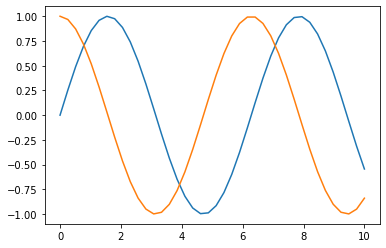

In [288]:
import matplotlib.pyplot as plt
import tikzplotlib

plt.plot(np.linspace(0, 10, 40), np.sin(np.linspace(0, 10, 40)))
plt.plot(np.linspace(0, 10, 40), np.cos(np.linspace(0, 10, 40)))
tikzplotlib.save("test.tex")
tikzplotlib.get_tikz_code()

In [479]:
import pandas as pd
from lightgbm.sklearn import LGBMClassifier
import numpy as np
import re
import shap

In [489]:
def preprocess(X, y):
    X = X.copy()
    y = y.copy()
    for col in X.select_dtypes(include=['category']):
        X[col] = X[col].cat.codes
        X.loc[X[col] < 0, col] = np.nan
        X[col] = X[col].astype('category')
    
    X = X[~y.isna()]
    y = y[~y.isna()]
    
    if isinstance(X.columns, pd.MultiIndex):
        X.columns = [re.sub(r'[^0-9a-zA-Z_-]+ ', '', '_'.join(col).strip()) for col in X.columns.values]
    else:
        X.columns = [re.sub(r'[^0-9a-zA-Z_-]+ ', '', col) for col in X.columns.values]
        
    y = y.cat.codes
    return X, y

def get_feature_importances(X, y, return_estimator=False, do_preprocess=True, clf=None):
    if do_preprocess:
        X, y = preprocess(X, y)
    
    if clf is None:
        clf = LGBMClassifier(n_jobs=-1)
        clf.fit(X, y)
    
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer(X)[:, :, 1]
    if return_estimator:
        return np.abs(shap_values.values * (~X.isna())).mean(axis=0), clf
    else:
        return np.abs(shap_values.values * (~X.isna())).mean(axis=0)

In [564]:
# X, y = load_breast_cancer(return_X_y=True)
X, y = preprocess(ictcf.Input.Clinical, ictcf.Target.pcr)
X = X.dropna(axis='columns', thresh=2)
is_union = ictcf.Meta.hospital == 'Union'
is_liyuan = ictcf.Meta.hospital == 'Liyuan'
# X_train = X[is_union].sample(n=X[is_liyuan].shape[0])
y_train = y.loc[X_train.index]

clf = LGBMClassifier(n_jobs=-1, use_missing=False).fit(X_train, y_train)
# preds = clf.predict_proba(X[])[:, 1]

In [565]:
import shap

In [566]:
X[is_union].sample(n=X[is_liyuan].shape[0]).shape, X[is_liyuan].shape

((264, 124), (264, 124))

In [567]:
explainer = shap.TreeExplainer(clf, data=X, model_output='log_loss')
shap_values = explainer(X[is_liyuan], y[is_liyuan], check_additivity=True)

In [568]:
X.Value_IFN

0       0.092179
1       0.130726
2            NaN
3       0.165922
4            NaN
          ...   
1516    0.090503
1517    0.149162
1518    0.157542
1519    0.103911
1520    0.160335
Name: Value_IFN, Length: 1273, dtype: float64

<BarContainer object of 2 artists>

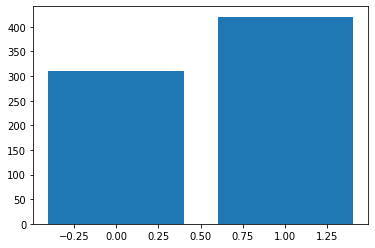

In [581]:
import matplotlib.pyplot as plt
plt.bar([0, 1], [((shap_values.values > 0) * shap_values.values * ~X[is_liyuan].isna()).sum().sum(), ((shap_values.values > 0) * shap_values.values * X[is_liyuan].isna()).sum().sum()])

All-NaN slice encountered


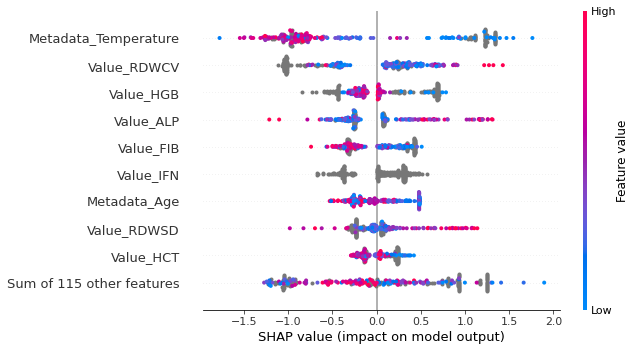

In [570]:
shap.plots.beeswarm(shap_values)

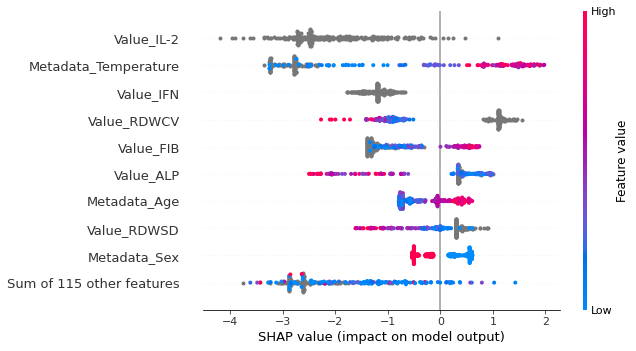

In [545]:
shap.plots.beeswarm(shap_values[:, :, 1])

In [438]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

In [464]:
inv_logit((shap_values.base_values) + shap_values.values.sum(axis=1)).max()

0.9999846123892768

In [470]:
from scipy.special import expit
shap_preds = inv_logit(shap_values.base_values[:, 1] + np.sum(shap_values[:, :, 1].values, axis=1))

In [473]:
np.allclose(shap_preds, preds)

True

In [415]:
shap_preds-preds

array([ 0.63610027,  0.63656048,  0.63656522,  0.63537536,  0.63535008,
        0.63380571,  0.63656083,  0.63646143,  0.63653717,  0.63630989,
        0.63389347,  0.63656582,  0.63651311,  0.63488432,  0.63595969,
        0.63649222,  0.63650061,  0.63656475,  0.63656227, -0.3554559 ,
       -0.35570344, -0.35571646,  0.63549859,  0.63656233,  0.63656273,
        0.63654632,  0.63654802,  0.63651769,  0.63656545,  0.63534663,
        0.63656527,  0.63631556,  0.63656525,  0.63656572,  0.63655762,
        0.63656295,  0.63618488, -0.35567104,  0.62987158,  0.63607634,
        0.6277689 ,  0.63076526,  0.63655612,  0.63646202,  0.63503684,
        0.63654536, -0.35571285,  0.63652296, -0.35564373, -0.35202227,
       -0.35570952, -0.35570599, -0.3557163 ,  0.63652308,  0.63614943,
       -0.35561768,  0.6365641 ,  0.63654419, -0.35561406, -0.35571041,
       -0.3556989 , -0.35569989,  0.63654223, -0.3557078 ,  0.63656492,
        0.63648163, -0.35570585, -0.35570644, -0.3541476 , -0.35